In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import os
import scipy
import networkx as nx

ImportError: No module named networkx

In [2]:
#data_dir = '/Users/Device6/Documents/Research/bgoodlab/fastsimbac/fastSimBac_mac/results'
data_dir = '/media/hdd/Research/fastsimbac' #os.path.join(config.analysis_directory, 'fastsimbac_data')
fig_dir = '/media/hdd/Research/microbiome' #os.path.join(config.analysis_directory, 'run_size_survival_distributions', 'fastSimBac')

In [15]:
def load_data(filename):
    f = open(os.path.join(data_dir, filename), 'r')
    data = []
    for line in f.read().splitlines()[:-5]:
        parts = line.split('\t')
        if len(parts) != 5:
            continue
        line_data = list(map(int, parts[-1]))
        line_data.append(float(parts[2]))
        data.append(line_data)
    f.close()
    return np.array(data)
        
def compare_two_samples(idx1, idx2, data, genome_len):
    locations = data[:, -1][np.nonzero(data[:, idx1] != data[:, idx2])]
    runs = locations[1:] - locations[:-1]
    runs = runs * genome_len
    return locations, runs.astype(int)

def get_snp_vector(idx1, idx2, data):
    return data[:, idx1] != data[:, idx2]

def get_block_snp_vector(idx1, idx2, data, genome_len=1e6, block_len=1e3):
    bins = np.arange(0, genome_len + 1, block_len)
    locations = data[:, -1][np.nonzero(data[:, idx1] != data[:, idx2])] * genome_len
    snp_vec, _ = np.histogram(locations, bins)
    return snp_vec

In [4]:
def plot_null(ax):
    # plot the unlinked null
    p = 0.01
    snps = np.random.binomial(1, p, size=int(1e6))
    locations = np.where(snps == 1)[0]
    run_lengths = locations[1:] - locations[:-1]
    p_emp = sum(snps) / 1e6
    _ = ax.hist(run_lengths * p_emp, density=True, bins=50, cumulative=-1, histtype='step', color='k')
    ax.plot([], color='k', label='independent null')


def plot_one_simulation(ax, filename, genome_len=1e6, num_curves=500, color='b', label=None, cutoff=None):
    data = load_data(filename)
    
    sample_size = data.shape[1] - 1
    pairs = [random.sample(range(sample_size), 2) for i in range(num_curves)]

    # plot the simulation
    divergences = []
    for pair in pairs:
        snp_locs, run_lens = compare_two_samples(pair[0], pair[1], data, genome_len)
        snp_count = len(snp_locs)
        div = snp_count / genome_len
        divergences.append(div)
        if cutoff:
            if div < cutoff:
                continue
        _ = ax.hist(run_lens * div, bins=100, cumulative=-1, histtype='step', color=color, density=True, alpha=0.1)
    ax.plot([], color=color, label=label)
    return np.array(divergences)

## Run lengths distribution plotting

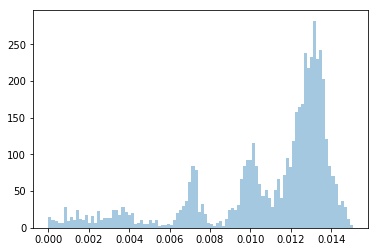

In [112]:
sample_size = 100
sim_data = load_data(filename)
divergences = []
pairs = []
for i in range(sample_size - 1):
        for j in range(i + 1, sample_size):
            snp_locs, run_lens = compare_two_samples(i, j, sim_data, genome_len)
            snp_count = len(snp_locs) + 1
            div = snp_count / genome_len
            divergences.append(div)
            pairs.append((i, j))
divergences = np.array(divergences)
pairs = np.array(pairs)

plt.figure()
sns.distplot(divergences, bins=100, kde=False)

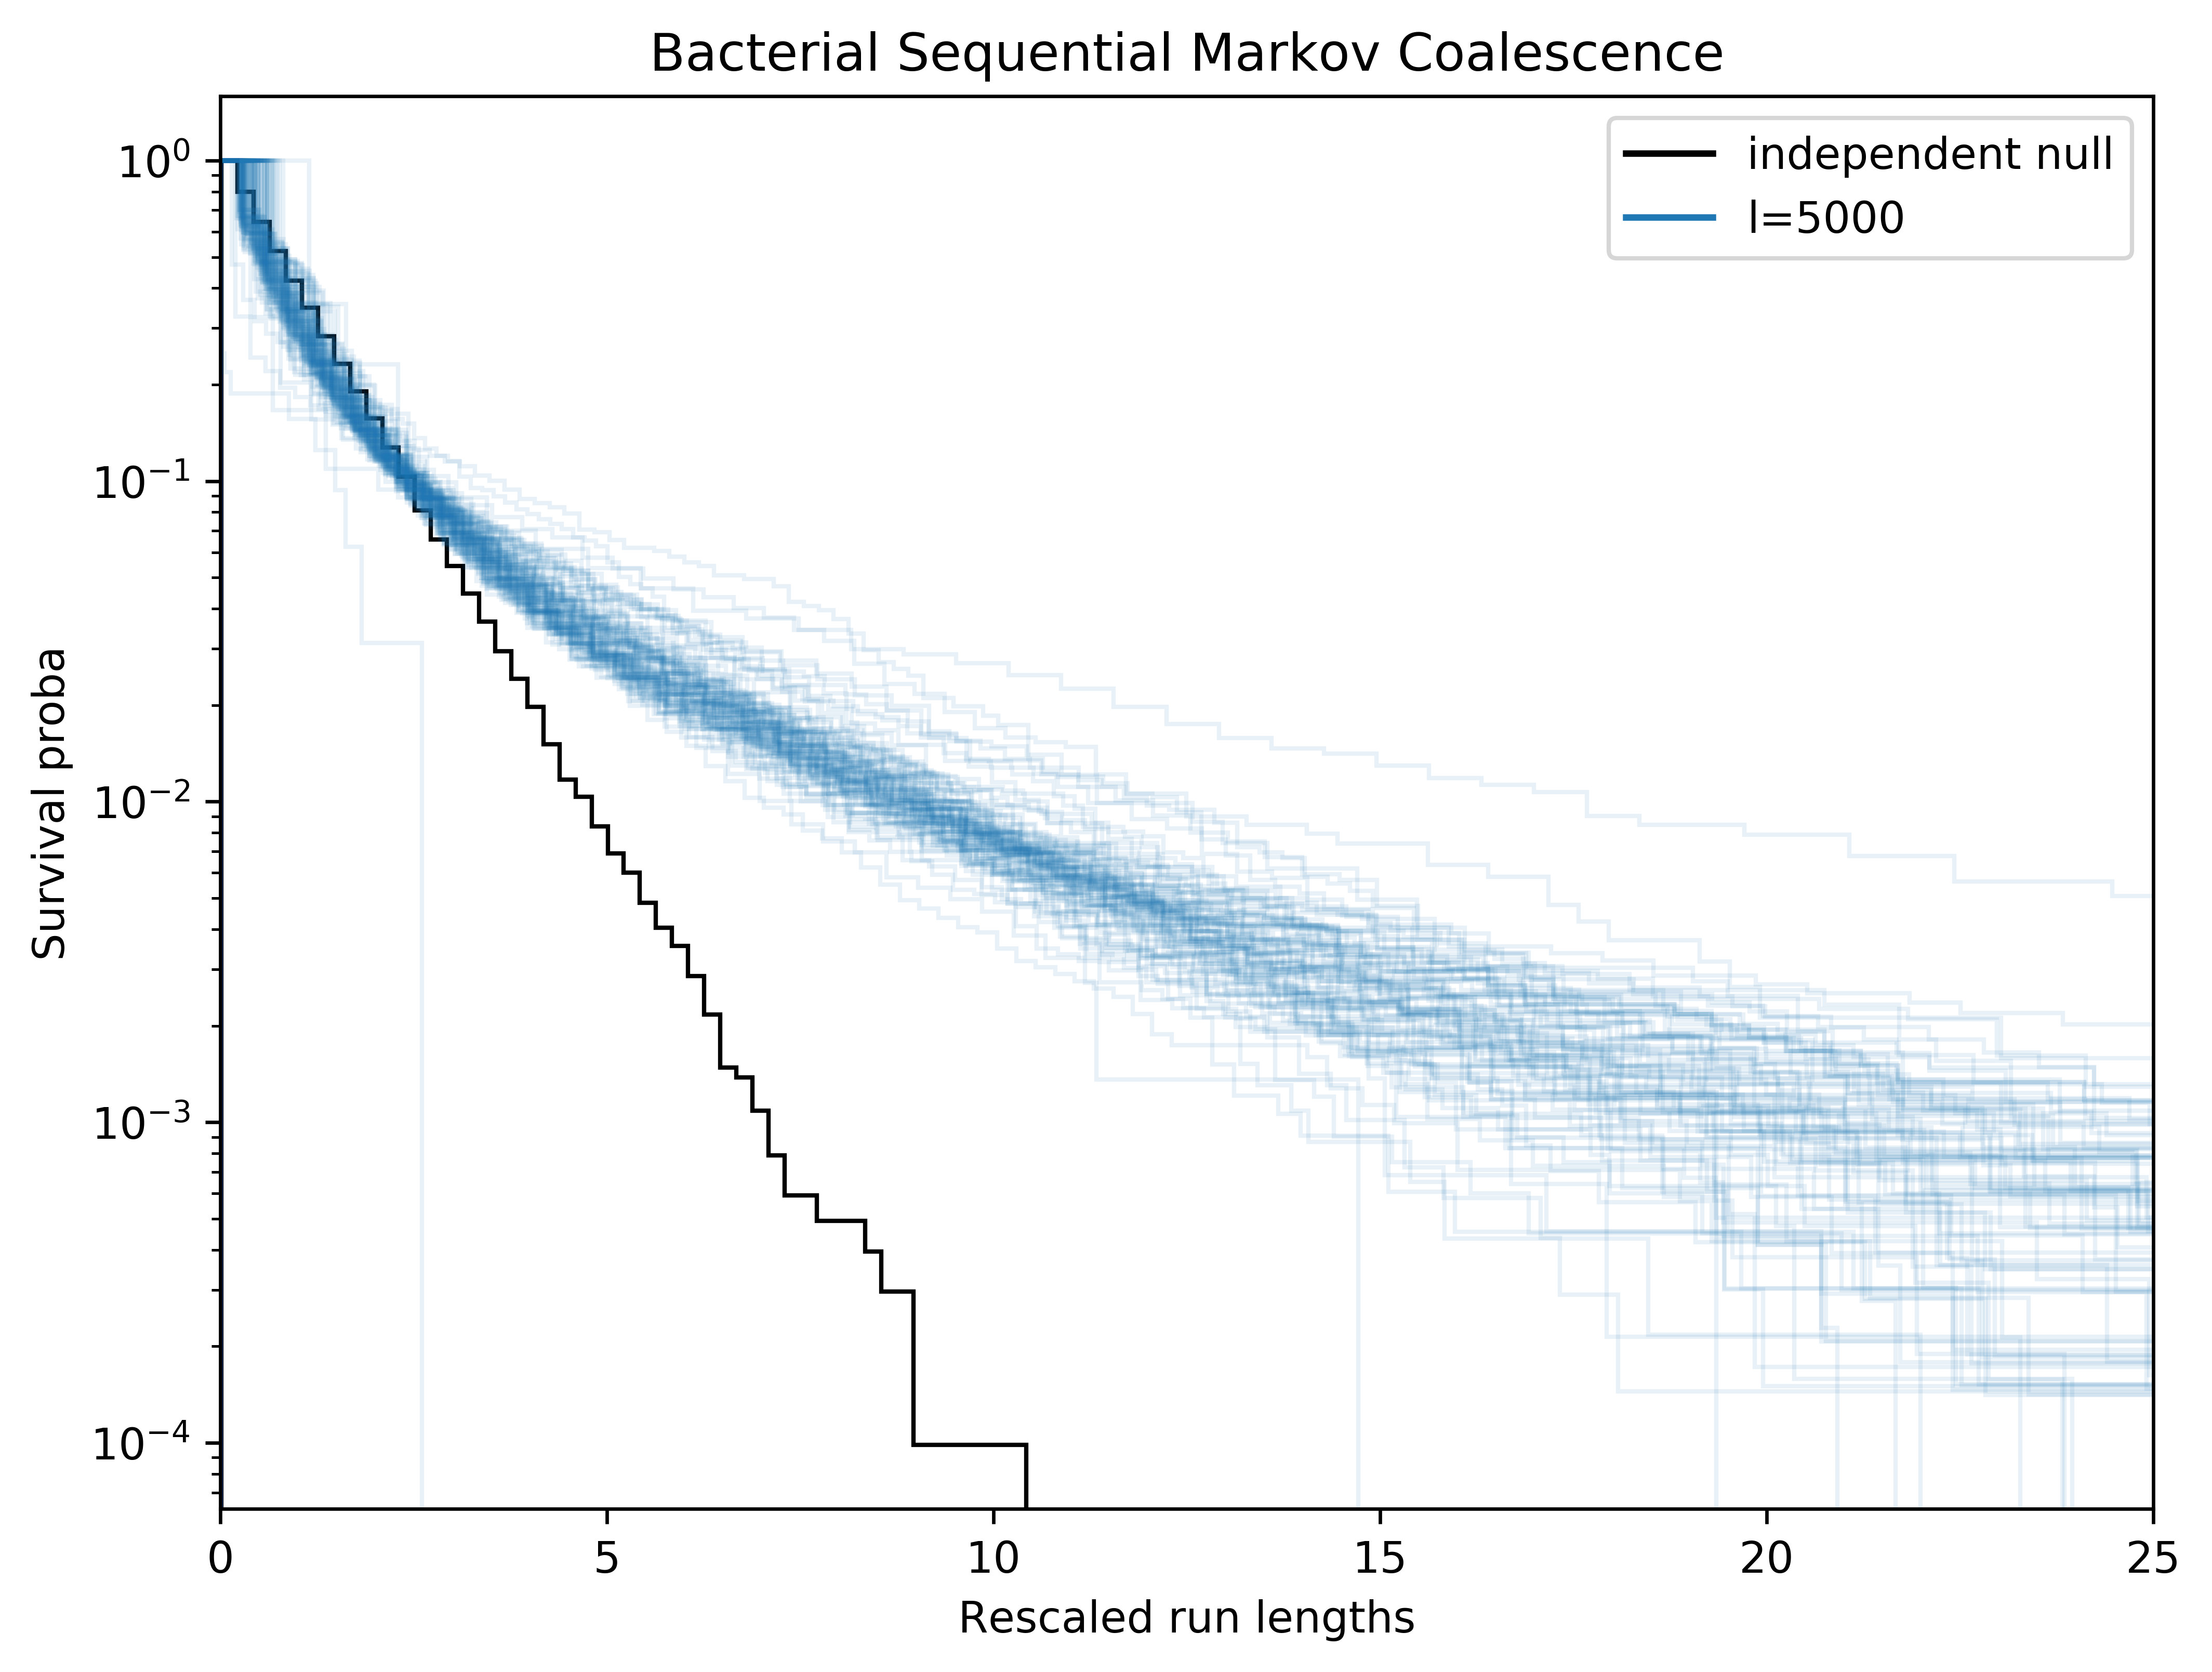

In [111]:
genome_len = 5e5
plt.figure(figsize=(8,6), dpi=600)

ax = plt.gca()
ax.set_yscale('log')

plot_null(ax)

colors = sns.color_palette()

all_divs = []

ax.set_xlim([0, 25])

rs = [0.001, 0.005, 0.01, 0.02]
ts = [0.01]
ls = [5000, 10000]
r = rs[0]
t = ts[0]
for j in range(1):
    lam = ls[j]
    filename = 'varying_rho/num_samples_100_genomelen_5e+05_r_%.3f_t_%.3f_tractlen_%d.txt' % (r, t, lam)
    divs = plot_one_simulation(ax, filename, num_curves=100, color=colors[j], label='l=%d'%lam)
    all_divs.append(divs)

ax.set_title('Bacterial Sequential Markov Coalescence')
ax.set_xlabel('Rescaled run lengths')
ax.set_ylabel('Survival proba')
ax.legend()

#plt.savefig(os.path.join(fig_dir, 'num_samples_100_genomelen_1e+06_r_%.3f_t_%.3f.pdf'%(r, t)))

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 9), dpi=600)

rs = [0.005, 0.01, 0.02]
ts = [0.001, 0.005, 0.01]
ls = [1000, 5000, 10000, 20000]

colors = sns.color_palette()

for i in range(3):
    for j in range(3):
        ax = axs[i, j]
        ax.set_xlim([0, 25])
        ax.set_yscale('log')
        plot_null(ax)
        r = rs[i]
        t = ts[j]
        for k in range(len(ls)):
            lam = ls[k]
            filename = 'parameter_space/num_samples_100_genomelen_1e+06_r_%.3f_t_%.3f_tractlen_%d.txt' % (r, t, lam)
            try:
                divs = plot_one_simulation(ax, filename, num_curves=100, color=colors[k], label='l=%d'%lam, cutoff=0.8 * t)
            except IOError:
                print("Skipping bad r_%.3f_t_%.3f_tractlen_%d" % (r, t, lam))
                continue
        ax.legend()
for i in range(3):
    axs[i, 0].set_ylabel('r=%.3f'%rs[i])
    axs[0, i].set_title('t=%.3f'%ts[i])
axs[2, 1].set_xlabel('Normalized run lengths')
plt.tight_layout()
fig.savefig(os.path.join(fig_dir, 'param_scan.pdf'))
plt.close()

In [ ]:
#Investigate the peak
data = load_data(filename)

In [ ]:
while True:
    idx1, idx2 = random.sample(range(100), 2)
    snp_vec = get_block_snp_vector(idx1, idx2, data)
    div = np.sum(snp_vec) / 1e6
    if div > 0.01:
        continue
    else:
        print(div)
        plt.plot(snp_vec)
        break

## Clonal simulation

In [ ]:
sample_size = 100
genome_len = 1e6
for i in range(1, 11):
    divergences = []
    pairs = []
    filename = 'clonal/100/num_samples_100_genomelen_1e+06_r_0.000_t_0.010_tractlen_5000_rep_{}.txt'.format(i)
    sim_data = load_data(filename)
    for i in range(sample_size - 1):
        for j in range(i + 1, sample_size):
            snp_locs, run_lens = compare_two_samples(i, j, sim_data, genome_len)
            snp_count = len(snp_locs) + 1
            div = snp_count / genome_len
            divergences.append(div)
            pairs.append((i, j))
    divergences = np.array(divergences)
    pairs = np.array(pairs)

    plt.figure()
    sns.distplot(divergences, bins=100, kde=False)

In [ ]:
gene_bins = np.arange(0, 1e6 + 1, 1000)
clonal_counts = []
recomb_counts = []
clonal_threshold = 1
for pair in pairs[np.nonzero(divergences < 0.0005)[0]]:
    snp_locs, run_lens = compare_two_samples(pair[0], pair[1], sim_data, genome_len)
    snps = snp_locs * genome_len
    histo = np.histogram(snps.astype(int), bins=gene_bins)
    snp_genes = histo[0]
    clonal_counts.append(len(np.nonzero((snp_genes <= clonal_threshold) & (snp_genes !=0))[0]))
    recomb_counts.append(len(np.nonzero(snp_genes > clonal_threshold)[0]))
    #plt.figure()
    #plt.plot(histo[0])

In [ ]:
plt.plot(clonal_counts, recomb_counts, '.')
slope, intercept, _, _, _ = scipy.stats.linregress(clonal_counts, recomb_counts)
xs = np.linspace(0, max(clonal_counts), 100)
plt.plot(xs, slope * xs + intercept, label="slope=%f"%slope)
plt.legend()

In [ ]:
np.mean(divergences)

In [ ]:
sns.distplot(divergences, bins=200, kde=False)

## Pairwise clonal simulation

In [ ]:
divergences = []
for i in range(1, 5001):
    filename = 'clonal/num_samples_2_genomelen_1e+06_r_0.000_t_0.010_tractlen_5000_rep_{}.txt'.format(i)
    sim_data = load_data(filename)
    snp_locs, run_lens = compare_two_samples(0, 1, sim_data, genome_len)
    snp_count = len(snp_locs) + 1
    div = snp_count / genome_len
    divergences.append(div)

In [ ]:
sns.distplot(divergences, kde=False, bins=100)

## Pile up plots

In [103]:
thresholds = [4000, 6000, 8000]
cumu_runs = np.zeros([int(genome_len), 3])
max_runs = []
reps = 0
for i in range(100):
    for j in range(i+1, 100):
        site_locations, runs = compare_two_samples(i, j, sim_data, genome_len)
        site_locations = np.array(site_locations * genome_len).astype(int)
        div = len(site_locations) / genome_len
        if div < 0.005:
            continue
#         runs = site_locations[1:] - site_locations[:-1]
        max_runs.append(max(runs) if len(runs) > 0 else 0)
        if len(runs) > 0 and max(runs) > 20000:
            print(i, j)
            print(div)
        for k in range(3):
            threshold = thresholds[k]
            event_starts = site_locations[:-1][runs > threshold]
            event_ends = site_locations[1:][runs > threshold]
            for start, end in zip(event_starts, event_ends):
                cumu_runs[start:end, k] += 1
        reps += 1

(6, 7)
0.00808
(7, 9)
0.008142
(10, 23)
0.01144
(10, 60)
0.011448
(12, 59)
0.011278
(17, 94)
0.005526
(18, 31)
0.010176
(18, 97)
0.010336
(22, 28)
0.012604
(22, 91)
0.011852
(36, 41)
0.010042
(36, 64)
0.010044
(36, 93)
0.01009
(49, 70)
0.012084
(59, 70)
0.011394
(59, 77)
0.011538
(59, 83)
0.011372
(70, 86)
0.012086
(74, 94)
0.0055


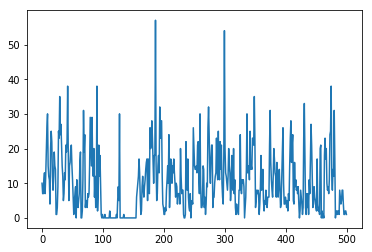

In [104]:
plt.plot(get_block_snp_vector(18, 97, sim_data, genome_len=5e5))

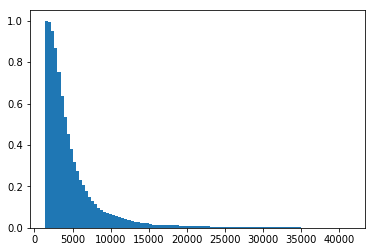

In [89]:
_ = plt.hist(max_runs, density=True, cumulative=-1, bins=100)

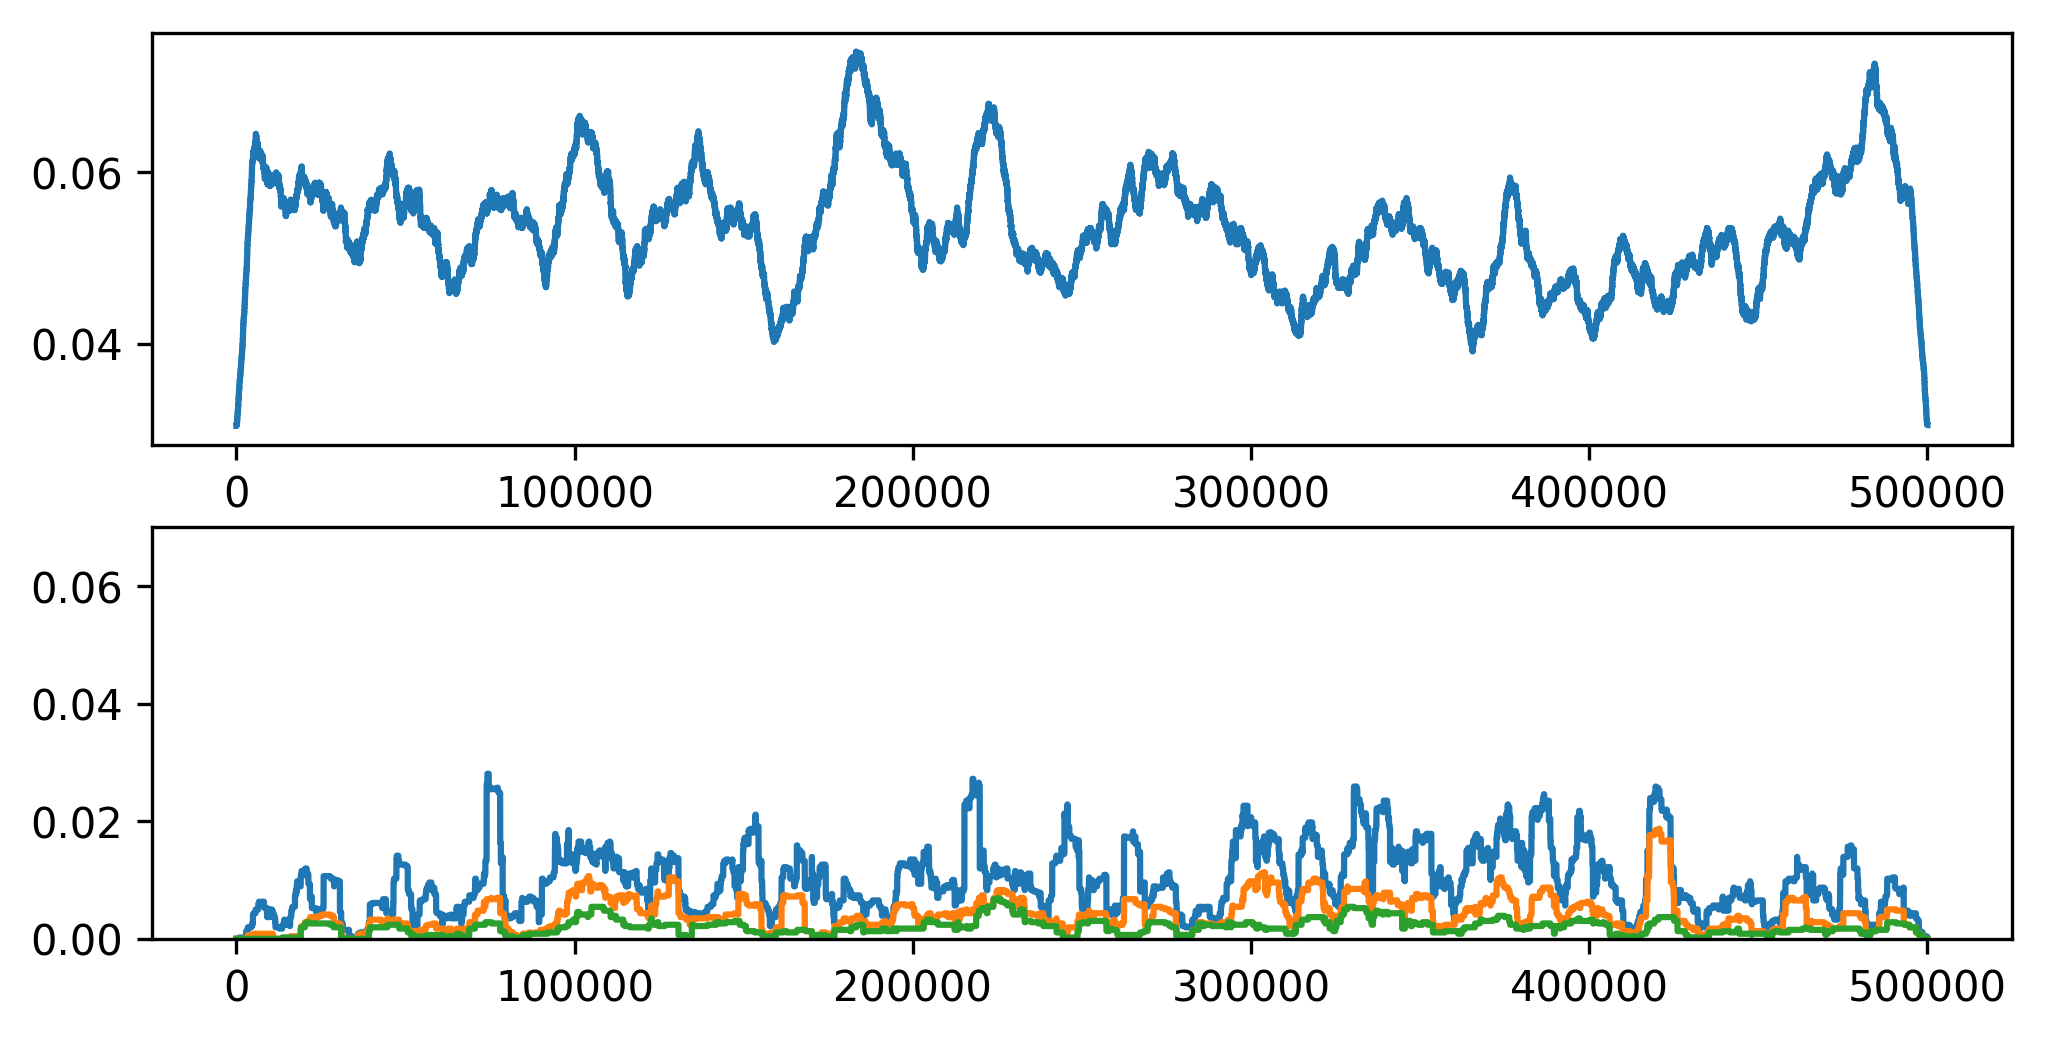

In [107]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4), dpi=300)
axes[1].set_ylim([0, 0.07])
locs = np.array(sim_data[:, -1] * genome_len).astype(int)
has_snp = np.zeros(int(genome_len))
has_snp[locs] = 1
snp_window = 10000
axes[0].plot(np.convolve(has_snp, np.ones(snp_window)/snp_window, mode='Same'))
for i in range(3):
    axes[1].plot(cumu_runs[:, i] / float(reps))

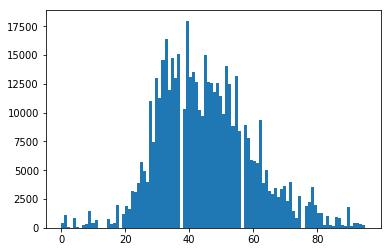

In [81]:
_ = plt.hist(cumu_runs[:, 0], bins=100)

## Coarse-graining into blocks (fake genes)

In [ ]:
os.chdir('/Users/Device6/Documents/Research/bgoodlab/microbiome_evolution/')
from utils import HGT_utils
import config

In [ ]:
filename1 = 'parameter_space/num_samples_100_genomelen_1e+06_r_0.005_t_0.001_tractlen_1000.txt'
data = load_data(filename1)

In [ ]:
all_runs_map = dict()
snp_counts_map = dict()
for i in range(100):
    for j in range(i+1, 100):
        snp_vec = get_block_snp_vector(i, j, data, genome_len=1e6, block_len=1e3)
        res = HGT_utils.find_runs(snp_vec)
        all_runs_map[(i, j)] = res
        snp_counts_map[(i, j)] = sum(snp_vec)

In [ ]:
thresholds = [0, 5, 10, 15]
final_cumu_runs = HGT_utils.cumulate_runs_by_thresholds(
    all_runs_map, snp_counts_map, (-1, 1e6), 1000, thresholds)

In [ ]:
fig = plt.figure()
ax = plt.gca()
for i in range(len(thresholds)):
    ax.plot(final_cumu_runs[i], label="Threshold %d" % thresholds[i])
    print(max(final_cumu_runs[i]))
ax.legend()
ax.set_ylim((0, len(all_runs_map)))
ax.figure.set_size_inches(12, 4)
ax.set_title('Cumulative long runs per gene')
ax.set_xlabel('Gene id')
ax.set_ylabel('Num runs')
#fig.savefig(os.path.join(config.analysis_directory, 'IBS_locations', 'synthetic/recombinant_r_0.010_t_0.010_tractlen_500.pdf'), dpi=600)

In [ ]:
for filename in os.listdir(os.path.join(data_dir, "parameter_space")):
    if filename.startswith('.'):
        continue
    else:
        filename_base = filename.split('.')[0]
        data = load_data(os.path.join("parameter_space", filename))
        
        all_runs_map = dict()
        snp_counts_map = dict()
        for i in range(100):
            for j in range(i+1, 100):
                snp_vec = get_block_snp_vector(i, j, data, genome_len=1e6, block_len=1e3)
                res = HGT_utils.find_runs(snp_vec)
                all_runs_map[(i, j)] = res
                snp_counts_map[(i, j)] = sum(snp_vec)
                
        thresholds = [0, 5, 10, 15]
        final_cumu_runs = HGT_utils.cumulate_runs_by_thresholds(
            all_runs_map, snp_counts_map, (-1, 1e6), 1000, thresholds)
        
        fig = plt.figure()
        ax = plt.gca()
        for i in range(len(thresholds)):
            ax.plot(final_cumu_runs[i], label="Threshold %d" % thresholds[i])
            print(max(final_cumu_runs[i]))
        ax.legend()
        ax.set_ylim((0, len(all_runs_map)))
        ax.figure.set_size_inches(12, 4)
        ax.set_title('Cumulative long runs per gene')
        ax.set_xlabel('Gene id')
        ax.set_ylabel('Num runs')
        fig.savefig(os.path.join(
            config.analysis_directory, 'IBS_locations', 'synthetic', "parameter_space",
        "%s.png"%filename), dpi=600)
        plt.close()
        
        fig = plt.figure()
        ax = plt.gca()
        ax.set_xlim([0, 1])
        for i in range(1, 4):
            _ = ax.hist(final_cumu_runs[i] / final_cumu_runs[0], cumulative=-1,
                        bins=100, density=True, label="Threshold %d" % thresholds[i])
        ax.legend()
        fig.savefig(os.path.join(
            config.analysis_directory, 'IBS_locations', 'synthetic', "ratios",
        "%s.png"%filename), dpi=600)
        plt.close()

In [ ]:
# polarize data
genotype = np.sum(data[:, :100], axis=1).astype(int) / 50

In [ ]:
polarized_data = data.copy()

In [ ]:
polarized_data[genotype == 1] = 1 - data[genotype == 1]

In [ ]:
marked_haplotypes = np.zeros((data.shape[1] - 1, 999 + data.shape[0], 3))
snp_idx = 0
block_size = 1000
curr_block = 0
block_snps = {}
block_snps[0] = []
for i in range(data.shape[0]):
    location = data[i, -1] * 1e6
    if int(location) / block_size > curr_block:
        marked_haplotypes[:, snp_idx, 1] = 1
        block_snps[curr_block] = np.array(block_snps[curr_block])
        snp_idx += 1
        curr_block += 1
        block_snps[curr_block] = []
    marked_haplotypes[:, snp_idx, 0] = polarized_data[i, :-1]
    marked_haplotypes[:, snp_idx, 2] = 1 - polarized_data[i, :-1]
    block_snps[curr_block].append(polarized_data[i, :-1])
    snp_idx += 1

In [ ]:
int(data[100, -1] * 1e6) / block_size

In [ ]:
block_snps[0].shape

In [ ]:
marked_haplotypes.shape

In [ ]:
fig = plt.figure()
fig.set_size_inches((60, 4))
plt.imshow(marked_haplotypes[flat_array, :500, :])

In [ ]:
def pairwise_divergence(haplotype_arr):
    # haplotype_arr: (num_sites, num_samples)
    num_samples = haplotype_arr.shape[1]
    dm = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(i+1, num_samples):
            dm[i, j] = np.sum(haplotype_arr[:, i] != haplotype_arr[:, j])
            dm[j, i] = np.sum(haplotype_arr[:, i] != haplotype_arr[:, j])
    return dm

def matrix_to_clusters(distance_matrix, allowed_snps=0):
    # return a list of list of indices. Each sublist is a cluster of haplotypes
    G = nx.from_numpy_matrix(distance_matrix <= allowed_snps)
    clusters = get_cluster_members(G)
    return [list(c) for c in clusters]

def get_cluster_members(G):
    sub_graphs = nx.connected_component_subgraphs(G)
    clusters = []
    for i, sg in enumerate(sub_graphs):
        clusters.append(sg.nodes)
    return clusters

In [ ]:
dist_m = pairwise_divergence(block_snps[6])
print(dist_m[0, 1])
clusters = matrix_to_clusters(dist_m)
cluster_sizes = [len(x) for x in clusters]
shared_pairs = np.sum([x*(x-1)/2 for x in cluster_sizes])
print(shared_pairs)
print(final_cumu_runs[0][6])
flat_array = np.array([x for c in clusters for x in c])

In [ ]:
ax = plt.gca()
for i in range(1000):
    dist_m = pairwise_divergence(block_snps[i])
    _ = ax.hist(dist_m.flatten(), cumulative=-1, histtype='step', alpha=0.1)

In [ ]:
_ = plt.hist(final_cumu_runs[0], bins=100)

## Getting local trees

In [ ]:
from Bio import Phylo
from cStringIO import StringIO

In [ ]:
filename = 'trees.txt'
data_dir = '/Users/Device6/Documents/Research/bgoodlab/fastsimbac/fastSimBac_mac/'

In [ ]:
f = open(os.path.join(data_dir, filename))
f.seek(0)
tree = Phylo.read(StringIO(tree_str), 'newick')
Phylo.draw(tree)

In [ ]:
import itertools

In [ ]:
def newick_to_matrix(newick_str):
    tree = Phylo.read(StringIO(newick_str), 'newick')
    num_leaves = len(tree.get_terminals())
    distance = np.zeros((num_leaves, num_leaves))
    for x, y in itertools.combinations(tree.get_terminals(), 2):
        i = int(x.name)
        j = int(y.name)
        distance[i, j] = tree.distance(x, y)
    return distance

def parse_line(line_str):
    s = line.split(';')[0]
    length = int(s[1:s.find(']')])
    tree_str = s[s.find(']')+1:]
    return length, tree_str

In [ ]:
import time
t0 = time.time()
loc = 0
tree_idx = 0
for line in f:
    if not line.startswith('['):
        continue
    l, tree_str = parse_line(line)
    with open('./trees/{}_{}.txt'.format(tree_idx, l), 'w') as save:
        save.write(tree_str)
    loc += l
    tree_idx += 1

## Experiment with Zarr saving

In [ ]:
data_dir = '/Users/Device6/Documents/Research/bgoodlab/fastsimbac/'
csv_dir = os.path.join(data_dir, 'postprocessing', 'matrices')

In [ ]:
filenames = filter(lambda x: not x.startswith('.'), os.listdir(csv_dir))

In [ ]:
filenames = sorted(filenames, key=lambda x: int(x.split('_')[0]))
spans = np.array(map(lambda x: int(re.findall('_([0-9]+).', x)[0]), filenames))

In [ ]:
zz = zarr.open('data/example.zarr', mode='w', shape=(100, 100, len(spans)), chunks=(10, 10, 100), dtype='i4')

In [ ]:
%%time
curr_loc=0
for i, name in enumerate(filenames):
    span = int(re.findall('_([0-9]+).', name)[0])
    arr = np.loadtxt(os.path.join(csv_dir, name), delimiter=',')
    z1[:, :, i] = arr
    if i > 100:
        break

In [ ]:
arr = np.loadtxt(os.path.join(csv_dir, filenames[0]), delimiter=',')

In [ ]:
a = np.zeros((100, 100, 5))

In [ ]:
a[:, :, :3] = np.repeat(arr[:, :, None], 3, axis=2)

In [ ]:
curr_loc

In [ ]:
np.savetxt('spans.txt', spans)